### Dependencies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
from dotenv import load_dotenv

from typing import Annotated, TypedDict, List, Dict, Any, Optional
from pydantic import BaseModel, Field

In [2]:
# from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage

In [3]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition   # used by a Node to decide whether to use a tool
from langchain.agents import Tool # required to conver function to tool

from langgraph.checkpoint.memory import MemorySaver
import uuid

In [4]:
from tqdm import tqdm
from IPython.display import Image, display

import gradio as gr

C:\Users\DELL\Desktop\New-Era-Projects\Data-Analyst-Assistant-App\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
load_dotenv()

True

### Test LangChain OpenAi Integration

OPENAI API USAGE

In [6]:
# # Create an LLM instance
# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# # Make a simple inference
# user_prompt = """
# What is the capital of the US

# """
# messages = [ HumanMessage(content=user_prompt), 
#              SystemMessage(content="Make sure to present your response in bullet point without markdown format")
#            ]

# response = llm.invoke(messages)

# print(response.content)

GOOGLE GENERATIVE API USAGE

In [22]:
gemini_api_key = os.getenv("GEMINI_API_KEY")

In [23]:
user_prompt = """
What is the capital of the US?
"""

messages = [ HumanMessage(content=user_prompt), 
             SystemMessage(content="Make sure to present your response in bullet point without markdown format and extra character.")
           ]


google_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    google_api_key=gemini_api_key
)
    
response = google_llm.invoke(messages)
print(response)
print(response.content)

content='The capital of the United States is **Washington, D.C.**' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--065f077b-ce3b-4420-8e4b-2b993a7f5612-0' usage_metadata={'input_tokens': 11, 'output_tokens': 44, 'total_tokens': 55, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 30}}
The capital of the United States is **Washington, D.C.**


---

GROQ

In [51]:
# key is explicitly imported from environment variable
# groq_api_key = os.getenv("GROQ_API_KEY")

In [7]:
user_prompt = """
What is the capital of the US?
"""

messages = [ HumanMessage(content=user_prompt), 
             SystemMessage(content="Make sure to present your response in bullet point without markdown format and extra character.")
           ]

groq_llm = ChatGroq(model="llama-3.3-70b-versatile")

response = groq_llm.invoke(messages)
print(response)
print(response.content)

content='* The capital of the US is Washington D.C.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 59, 'total_tokens': 71, 'completion_time': 0.025087032, 'prompt_time': 0.012629729, 'queue_time': 0.086848075, 'total_time': 0.037716761}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--be8a69e9-55c6-4538-8007-e5373818b6b9-0' usage_metadata={'input_tokens': 59, 'output_tokens': 12, 'total_tokens': 71}
* The capital of the US is Washington D.C.


### Assistant Evaluator 

**Schema**

In [8]:
class EvaluatorResponse(BaseModel):
    feedback: str = Field(description="Critical feedback on the assistant response")
    success_criteria_met: bool = Field(description="Whether the success criteria has been met") # the users request is the criteria
    user_input_needed: bool = Field(description="True if more input is needed from the user for more clarity of the LLM get stucked")

Gemini Evaluator

In [10]:
evaluator_llm = ChatGoogleGenerativeAI( model="gemini-2.5-flash", 
                                       temperature=0, 
                                       google_api_key=gemini_api_key)

evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorResponse)

response = evaluator_llm_with_output.invoke(messages)
print(response)

Groq Evaluator

In [11]:
evaluator_llm_with_output = groq_llm.with_structured_output(EvaluatorResponse)

response = evaluator_llm_with_output.invoke(messages)
print(response)

feedback='The capital of the US is Washington, D.C.' success_criteria_met=True user_input_needed=False


### Data

In [12]:
def create_df():
    df = pd.read_csv("Customer.csv")
    return df

In [13]:
df = create_df()
df.head()

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0
3,270181,10-01-1970,F,2.0
4,268073,11-01-1970,M,1.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_Id  5647 non-null   int64  
 1   DOB          5647 non-null   object 
 2   Gender       5645 non-null   object 
 3   city_code    5645 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 176.6+ KB
{'messages': [HumanMessage(content='Thank you', additional_kwargs={}, response_metadata={}, id='ee910d90-bff1-4f3f-b01a-4cb001db4255'), AIMessage(content="You're welcome", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 276, 'total_tokens': 280, 'completion_time': 0.015351442, 'prompt_time': 0.022229633, 'queue_time': 0.093136228, 'total_time': 0.037581075}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--af788

----
### State Definition

In [14]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    success_criteria: str
    feedback_on_assist: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool

In [16]:
shared_data = {"df": None}

def load_csv(file):
    """
    Loads a CSV file into shared_data['df'] and returns a status message.
    """
    if file is None:
        return "⚠️ No file uploaded yet."

    try:
        df = pd.read_csv(file.name if hasattr(file, "name") else file)
        shared_data["df"] = df

        nrows, ncols = df.shape
        response_message = (
            f"✅ CSV loaded successfully! "
            f"Your dataset has {nrows} rows and {ncols} columns."
        )
    except Exception as e:
        response_message = f"❌ Error reading CSV: {e}"

    return response_message

In [17]:
def tool_data_summary(state: State) -> str:
    df = shared_data['df']
    
    summary = ["summary of dataframe:"]
    summary.append(f"\n\nDataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")

    # Column info
    col_info = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "missing_values": df.isnull().sum(),
        "non_null_count": df.notnull().sum()
    })
    summary.append("Column Information:\n")
    summary.append(col_info.to_string())
    summary.append("\n")

    return "\n".join(summary)


tool_summary = Tool(name="summarize_data", 
                    func=tool_data_summary, 
                    description=f"Returns the shape and summary of an existing dataframe {shared_data['df']} including numerical and non-numerical fields. Use this tool when the user asks for a data summary."
                )

tools = [tool_summary]

In [18]:
groq_llm_with_tools = groq_llm.bind_tools(tools)

In [19]:
def decides_if_tool(state: State):
    """
    The agent's output is an AIMessage that contains a tool_call object
    """
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "tools"
    return "end"

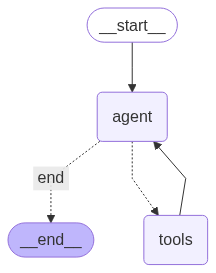

In [20]:
def assistant(state: State):
    return {"messages": [groq_llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node('agent', assistant)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges("agent", decides_if_tool, {"tools":"tools", "end": END})
graph_builder.add_edge("tools", "agent")

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
def chat(user_input: str, history):
    message = [HumanMessage(content=user_input)]
    result = graph.invoke({"messages": message}) # last state
    print(result)
    return result["messages"][-1].content  # the content of the AIMessage


with gr.Blocks() as demo:
    gr.Markdown("# 📊 Data Analyst Assistant")
    gr.Markdown("Upload a CSV file and then chat with the assistant.")

    with gr.Row():
        csv_input = gr.File(label="Upload CSV", file_types=[".csv"])
        csv_output = gr.Textbox(label="Upload Status", interactive=False)

    csv_input.change(fn=load_csv, inputs=csv_input, outputs=csv_output)

    gr.ChatInterface(fn=chat, type="messages")

# Launch the app
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='083452a2-1c02-47e1-abd9-b545a99233f3'), AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 275, 'total_tokens': 285, 'completion_time': 0.031589816, 'prompt_time': 0.028547247, 'queue_time': 0.086100464, 'total_time': 0.060137063}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--a71a2526-f81f-4c70-b133-cb7c69d2a93a-0', usage_metadata={'input_tokens': 275, 'output_tokens': 10, 'total_tokens': 285})]}
{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='732645ad-b470-4d17-b89c-847c3cb50428'), AIMessage(content='Hello, how can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 275, 'to

---

### Customised Tools

This tool can be used as a node in a graph

In [15]:
def tool_data_summary(state: State) -> State:
    """
    Returns a summary of the dataset including:
    - Shape (rows, columns)
    - Column names and data types
    - Count of missing values per column
    - Basic statistics for numeric columns
    - Top unique values for categorical columns
    """
    df = shared_data['df']
    
    summary = []
    summary.append(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")

    # Column info
    col_info = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "missing_values": df.isnull().sum(),
        "non_null_count": df.notnull().sum()
    })
    summary.append("Column Information:\n")
    summary.append(col_info.to_string())
    summary.append("\n")

    # Numeric stats
    numeric_desc = df.describe(include=[float, int]).transpose()
    summary.append("Numeric Column Statistics:\n")
    summary.append(numeric_desc.to_string())
    summary.append("\n")

    # Categorical stats
    cat_desc = df.describe(include=[object, "category"]).transpose()
    if not cat_desc.empty:
        summary.append("Categorical Column Summary:\n")
        summary.append(cat_desc.to_string())
        summary.append("\n")

    return {
                **state,  # keep previous state values
                "messages": state["messages"] + [{"role": "assistant", "content": "\n".join(summary)}]
            }


# print(tool_data_summary(df))


In [16]:
tool_summary = Tool(name="summarize_data", 
                    func=tool_data_summary, 
                    description="Returns the summary of uploaded data including statistics for numerical and non-numerical fields.")

### Agents and List of Tools

In [17]:
tools = [tool_summary]

In [18]:
# agent_llm =  ChatOpenAI(model="gpt-4o-mini", temperature=0)
google_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    google_api_key=os.getenv("GEMINI_API_KEY")
)
# bind tools to LLM
google_llm__with_tools = google_llm.bind_tools(tools)

### Nodes

In [19]:
def assistant(state: State) -> Dict[str, Any]:
    """
    Worker function that manages system instructions and invokes the LLM with tools.

    This function ensures the assistant always has an up-to-date system message
    guiding its behavior (e.g., role, success criteria, or feedback from prior attempts).
    It updates or prepends a SystemMessage to the conversation history, sends the
    updated messages to the LLM, and returns the assistant's latest response.

    Workflow:
        1. Construct a dynamic system message based on:
            - The success criteria from state
            - Optional feedback on previous work
        2. Check if a SystemMessage already exists in state["messages"]:
            - If yes, update its content with the new system message
            - If no, prepend a new SystemMessage to the messages list
        3. Invoke the LLM (with tools enabled) on the updated message history
        4. Return the new assistant response so it can be merged into state

    Args:
        state (State): The current state containing conversation history, 
                       success criteria, and optional feedback.

    Returns:
        dict: A partial state update containing:
            - "messages": A list with the assistant's latest response message.
    """
    system_message = f"""
        You are a data analyst assistant that collaborates with tools to complete analysis tasks. 
        Your role is to:
        - Present results from tools clearly and accurately to the user
        - Provide context, explanations, or next steps if helpful
        - Ask the user clarifying questions if needed
        - Stop once the success criteria is met
        
        The success criteria for this task is:
        {state['success_criteria']}
        
        If a tool has returned an analysis, include that result in your reply rather than repeating the analysis yourself.
        If the task is incomplete or ambiguous, ask a clear question to the user.
        If the task is complete, present the final analysis/answer.
    """

    # Add rejection feedback (if any)
    if state.get("feedback_on_assist"):
        system_message += f"""
            Previously, you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
            Here is the feedback on why this was rejected:
            {state['feedback_on_assist']}
            With this feedback, please continue the assignment, ensuring that you meet the success criteria or ask a question to the user if 
            the data is missing.
        """
    
    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True

    # prepend system message if it does not already exists
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    response = google_llm__with_tools.invoke(messages)
    
    return {
        "messages": state["messages"] + [response]
    }

In [20]:
def decides_if_tool(state: State):
    """
    Router function that decides the next node in the graph 
    based on the assistant's most recent message.

    The function inspects the last message in the conversation:
      - If the message contains a tool call, the flow should continue 
        to the "tools" node for execution.
      - Otherwise, the flow proceeds to the "evaluator" node to 
        check if the assistant's response meets the success criteria.

    Args:
        state (State): The current state containing the conversation 
                       history and other workflow metadata.
  
    Returns:
        str: The label of the next node to route to.
             - "tools" if the last message requests a tool call
             - "evaluator" if no tool call is present
    """
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "tools"
    return "evaluator"

In [21]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation


def evaluator(state: State) -> State:
    last_response = state["messages"][-1].content

    system_message = """
        You are an evaluator that determines if a task has been completed successfully by an Assistant.
        Assess the Assistant's last response based on the given criteria. Respond with your feedback, and with your decision on whether 
        the success criteria has been met, and whether more input is needed from the user.
    """
    
    user_message = f"""
        You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.

        The entire conversation with the assistant, with the user's original request and all replies, is:
        {format_conversation(state['messages'])} 
        
        The success criteria for this assignment is:
        {state['success_criteria']}
        
        And the final response from the Assistant that you are evaluating is:
        {last_response}
        
        Respond with your feedback, and decide if the success criteria is met by this response.
        Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and 
        unable to answer without help.
    """
    if state["feedback_on_assist"]:
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state['feedback_on_assist']}\n"
        user_message += "If you're seeing the Assistant repeating the same mistakes, then consider responding that user input is required."
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
    
    new_state = {
        "messages": [AIMessage(content=f"Evaluator Feedback on this answer: {eval_result.feedback}")],
        "feedback_on_assist": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed 
    }
    return new_state

In [22]:
def decides_based_on_evaluation(state: State) -> str:
    if state["success_criteria_met"] or state["user_input_needed"]:
        return "END"
    else:
        return "assistant"

### Build Graph
* Connect nodes
* Compile the graph with memory saver

In [23]:
graph_builder = StateGraph(State)

In [24]:
graph_builder.add_node("assistant", assistant)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_node("evaluator", evaluator)

In [25]:
graph_builder.add_edge(START, "assistant")
graph_builder.add_conditional_edges("assistant", decides_if_tool, {"tools": "tools", "evaluator": "evaluator"})
graph_builder.add_edge("tools", "assistant")
graph_builder.add_conditional_edges("evaluator", decides_based_on_evaluation, {"assistant": "assistant", "END": END})

**Compile the nodes and edges**

In [26]:
session_data = {"thread_id": None}

def get_thread_id():
    if session_data["thread_id"] is None:
        session_data["thread_id"] = str(uuid.uuid4())  
    return session_data["thread_id"]

memory = MemorySaver()

In [27]:
graph = graph_builder.compile(checkpointer=memory)

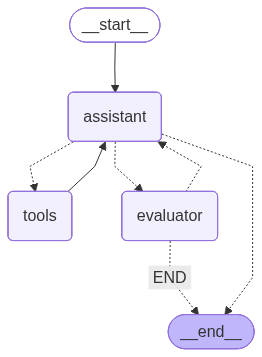

In [28]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Gradio App

**Data Handler**

In [29]:
shared_data = {"df": None}

def load_csv(file):
    """
    Loads a CSV file into shared_data['df'] and returns a status message.
    """
    if file is None:
        return "⚠️ No file uploaded yet."

    try:
        df = pd.read_csv(file.name if hasattr(file, "name") else file)
        shared_data["df"] = df

        nrows, ncols = df.shape
        response_message = (
            f"✅ CSV loaded successfully! "
            f"Your dataset has {nrows} rows and {ncols} columns."
        )
    except Exception as e:
        response_message = f"❌ Error reading CSV: {e}"

    return response_message


**Chat Han**

In [30]:
def chat_with_assistant(user_input, history):
    if shared_data["df"] is None:
        return "Please upload a CSV file first."
    
    state = {
        "messages": [HumanMessage(content=user_input)],
        "success_criteria": "Provide insights based on the uploaded CSV dataset.",
        "feedback_on_assist": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }

    thread_id =  get_thread_id()
    result = graph.invoke(state, config={"configurable": {"thread_id": thread_id}})

    print(result)
    # Get last assistant message safely
    last_msg = result["messages"][-1]
    return getattr(last_msg, "content", str(last_msg))

**Application Block**

In [31]:
with gr.Blocks() as demo:
    gr.Markdown("# 📊 Data Analyst Assistant")
    gr.Markdown("Upload a CSV file and then chat with the assistant.")

    with gr.Row():
        csv_input = gr.File(label="Upload CSV", file_types=[".csv"])
        csv_output = gr.Textbox(label="Upload Status", interactive=False)

    csv_input.change(fn=load_csv, inputs=csv_input, outputs=csv_output)

    gr.ChatInterface(fn=chat_with_assistant, type="messages")

# Launch the app
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [32]:
df = pd.DataFrame({"a": [1,2,3], "b": ["x","y","z"]})
shared_data["df"] = df
state = {"messages": [HumanMessage(content="summarize the dataset")]}
print(tool_data_summary(state)["messages"])

[HumanMessage(content='summarize the dataset', additional_kwargs={}, response_metadata={}), {'role': 'assistant', 'content': 'Dataset contains 3 rows and 2 columns.\n\nColumn Information:\n\n    dtype  missing_values  non_null_count\na   int64               0               3\nb  object               0               3\n\n\nNumeric Column Statistics:\n\n   count  mean  std  min  25%  50%  75%  max\na    3.0   2.0  1.0  1.0  1.5  2.0  2.5  3.0\n\n\nCategorical Column Summary:\n\n  count unique top freq\nb     3      3   x    1\n\n'}]
